# Imports

In [ ]:
!gdown https://drive.google.com/uc?id=18iSMK5cmBA5V8zc18-jIB2Vel6pnVHBI -O "04-files.zip"
!unzip -o 04-files.zip

Downloading...
From: https://drive.google.com/uc?id=18iSMK5cmBA5V8zc18-jIB2Vel6pnVHBI
To: /content/04-files.zip
100% 15.8M/15.8M [00:00<00:00, 107MB/s] 
Archive:  04-files.zip
   creating: 04-files/
  inflating: __MACOSX/._04-files     
  inflating: 04-files/cars.jpg       
  inflating: __MACOSX/04-files/._cars.jpg  
  inflating: 04-files/IMG_5781.JPG   
  inflating: __MACOSX/04-files/._IMG_5781.JPG  
  inflating: 04-files/IMG_5782.JPG   
  inflating: __MACOSX/04-files/._IMG_5782.JPG  
  inflating: 04-files/IMG_5783.JPG   
  inflating: __MACOSX/04-files/._IMG_5783.JPG  
  inflating: 04-files/.DS_Store      
  inflating: __MACOSX/04-files/._.DS_Store  
  inflating: 04-files/fusion-building.jpg  
  inflating: __MACOSX/04-files/._fusion-building.jpg  
  inflating: 04-files/cars2.jpg      
  inflating: __MACOSX/04-files/._cars2.jpg  
  inflating: 04-files/chessboard.jpg  
  inflating: __MACOSX/04-files/._chessboard.jpg  
  inflating: 04-files/pedestrians.jpg  
  inflating: __MACOSX/04-file

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import trange

In [ ]:
def show_img(im, ax=None, figsize=(8,8)):
    if not ax: _,ax = plt.subplots(1,1,figsize=figsize)
    if len(im.shape)==2: im = np.tile(im[:,:,None], 3)
    ax.imshow(im[:,:,::-1]);
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax

In [ ]:
def show_imgs(ims, rows=1, figsize=(16,8)):
    _,ax = plt.subplots(rows, len(ims)//rows, figsize=figsize)
    [show_img(im,ax_) for im,ax_ in zip(ims,ax.flatten())]
    return ax

# HOG (Histograms of Oriented Gradients)

HOG is yet another type of descriptor which works particularly well for object detection tasks (e.g. detecting a car or a pedestrian in an image). The idea is that appearance of any object can be described with distribution of edge directions (i.e. *histogram* of *oriented gradients*).

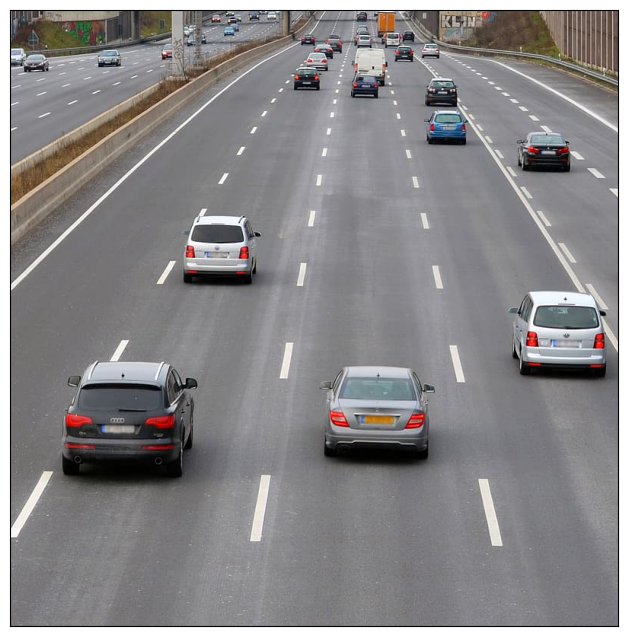

In [ ]:
im = cv2.imread('04-files/cars.jpg')
show_img(im);

((128, 128, 3), (128, 128, 3))

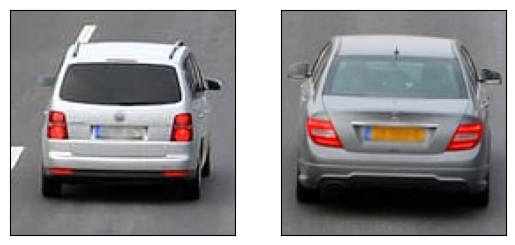

In [ ]:
im_car1 = im[252:380, 210:338].copy()
im_car2 = cv2.resize(im[450:610, 402:562], (128,128))

_,ax = plt.subplots(1,2)
show_img(im_car1, ax[0]);
show_img(im_car2, ax[1]);

im_car1.shape, im_car2.shape

HOG can be used at various scales (image pyramid), but the aspect ratio of the patch is fixed once you choose it. In our case it is 1:1, for tall objects you can decide on for example 2:1, or whatever suits your application.

## Gradients

Gradient calculation using the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator). This is done for each of the RGB channels separately.

In [ ]:
gradX = cv2.Sobel(im_car1, ddepth=cv2.CV_32F, dx=1, dy=0) # reveal vertical edges
gradY = cv2.Sobel(im_car1, ddepth=cv2.CV_32F, dx=0, dy=1) # reveal horizontal edges
gradX.min(),gradX.max(),gradX.shape

(-856.0, 979.0, (128, 128, 3))

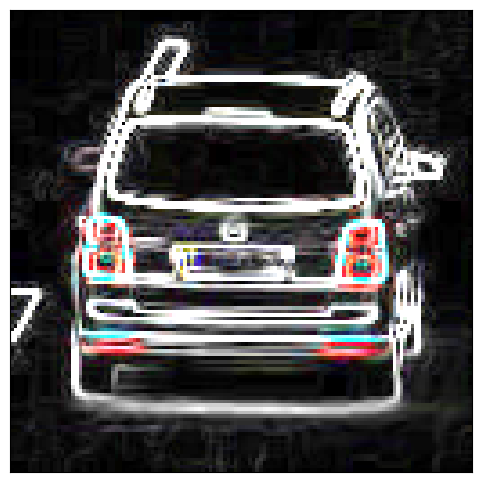

In [ ]:
# gradient magnitude and angle/direction
grad = cv2.convertScaleAbs(np.sqrt(gradX**2 + gradY**2))  # magnitude is just the length; we normalize with cv2.convertScaleAbs()
angles = np.mod(np.arctan(gradY/(gradX+1e-10)) * 180/np.pi + 180, 180)  # mod() for unsigned gradients

show_img(grad, figsize=(6,6));

Gradients are high when intensity changes a lot (sharp edges and corners). For flat areas like the road, gradients are small.

At any location gradient magnitude is the maximum over the three colour channels. Gradient angle is the angle **corresponding to the maximum gradient**.

In [ ]:
ix = np.argmax(grad, axis=-1)  # for each pixel ix tells us which channnel has the highest gradient

In [ ]:
ix[30:40,30:40]  # for each pixel tells me which channel had the highest gradient

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 1, 0, 0, 2, 2, 2],
       [0, 0, 0, 2, 0, 2, 2, 2, 0, 0],
       [0, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 0, 0, 0, 0, 0, 1, 1]])

If I now want to get the angles corresponding to max gradients or the gradients themselves:

In [ ]:
I,J = np.indices(ix.shape) # need full index matrix for each axis
I,J

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [125, 125, 125, ..., 125, 125, 125],
        [126, 126, 126, ..., 126, 126, 126],
        [127, 127, 127, ..., 127, 127, 127]]),
 array([[  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127],
        ...,
        [  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127],
        [  0,   1,   2, ..., 125, 126, 127]]))

In [ ]:
angles[I,J,ix].shape

(128, 128)

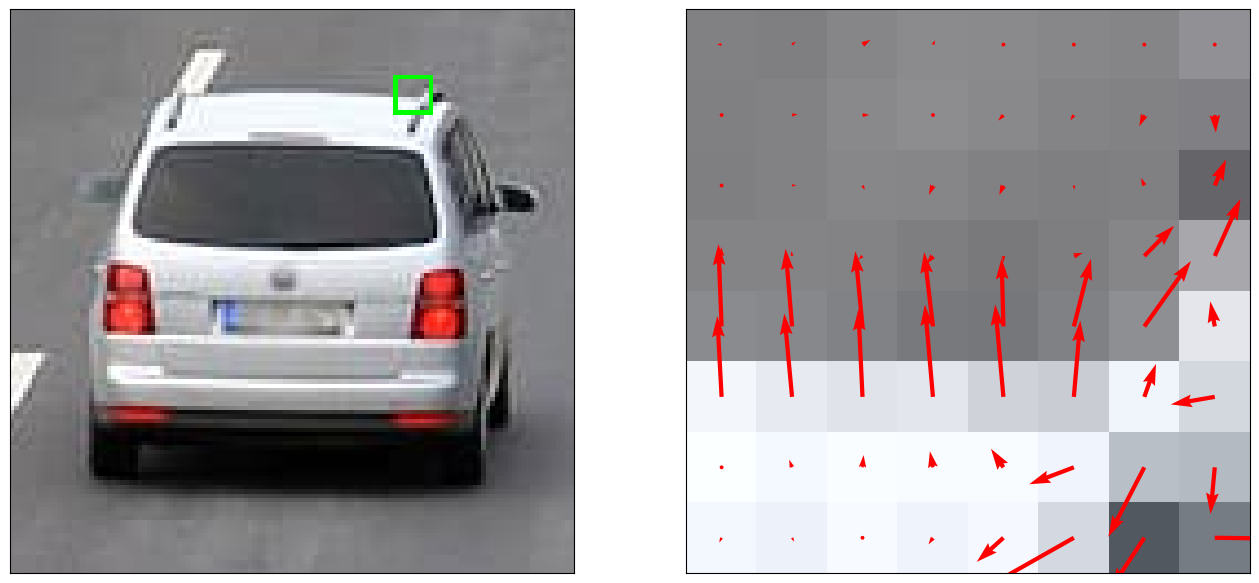

In [ ]:
sr, sc = slice(15,23), slice(87,95)  # 'range' would work here too
ax = show_imgs((cv2.rectangle(im_car1.copy(), (sc.start,sr.start), (sc.stop,sr.stop), (0,255,0)), im_car1[sr,sc]))
ax[1].quiver(gradX[I,J,ix][sr,sc], gradY[I,J,ix][sr,sc], color='red');

## Histogram

We want a descriptor for each 8x8* patch. Note how this approach is different from SIFT/SURF where we would first look for keypoints and calculate descriptors for those.

\* this is what worked well in the paper that proposed HOG; other sizes are possible

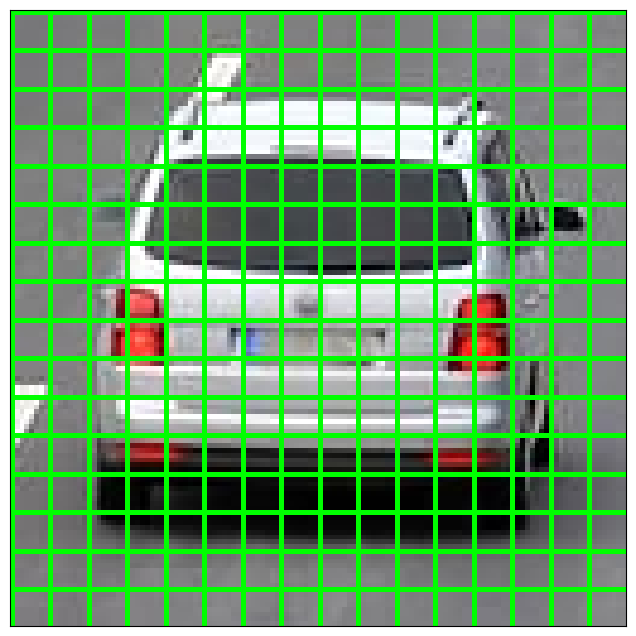

In [ ]:
im_copy = im_car1.copy()
for x in range(im_copy.shape[1]//8):
    for y in range(im_copy.shape[0]//8):
        cv2.rectangle(im_copy, (x*8, y*8), ((x+1)*8, (y+1)*8), (0,255,0), 1)

ax = show_img(im_copy)

In [ ]:
# max gradients and corresponding angles for the whole image
grad_mx = grad[I,J,ix]
angles_mx = angles[I,J,ix]

# max gradients and corresponding angles for the patch defined by sr,sc
grad_p = grad_mx[sr,sc]
angles_p = angles_mx[sr,sc]

grad_p, angles_p

(array([[ 26,  27,  51,  27,  22,  18,  22,  11],
        [ 11,  31,  38,  18,  42,  36,  68,  98],
        [ 11,  24,  28,  56,  58,  24,  46, 158],
        [ 50,  27,  31,  58,  35,  52, 236, 255],
        [255, 255, 255, 255, 255, 255, 255, 141],
        [255, 255, 255, 255, 255, 255, 194, 248],
        [ 23,  45,  68,  91, 124, 255, 255, 255],
        [ 30,  25,  19,  45, 200, 255, 255, 255]], dtype=uint8),
 array([[175.60129  ,  38.990997 ,  30.579224 ,  63.43495  , 146.30994  ,
           6.3401947, 158.1986   , 127.874985 ],
        [ 45.       ,   9.1623535,   0.       ,  83.65979  ,  46.90915  ,
          56.309937 ,  65.69545  ,  93.50353  ],
        [ 74.74487  ,   4.7636414, 117.47444  ,  67.0679   ,  66.54097  ,
          99.462326 , 113.19859  ,  66.515884 ],
        [ 92.29061  ,  96.340195 ,  42.39743  ,  50.572205 ,  91.63658  ,
          19.133636 ,  45.34308  ,  65.719666 ],
        [ 92.25065  ,  94.76365  ,  95.46621  ,  96.766174 ,  91.50744  ,
          75.78415 

Our histogram will have 9 bins (each `8x8x3` patch will be represented by 9 numbers which gives a *compact* representation), 20 degrees apart (i.e. at 0, 20, ... 160 degrees).

Angles above 160 degrees contribute both to the last and first bin (wrap around 180), proportionally.

In [ ]:
bins = np.arange(-20,181,20) # create 11 bins to make calculations easier, will remove the first and last later
bins

array([-20,   0,  20,  40,  60,  80, 100, 120, 140, 160, 180])

In [ ]:
def hog_descr(grad_p, angles_p, debug=False):
    bin_cnts = np.zeros((11,)) # initilize all counts with 0s

    for g,a in zip(grad_p.flatten(),angles_p.flatten()):

        # which bin(s) for angle 'a'?
        b1 = np.argwhere(a>bins).max()
        b2 = np.argwhere(a<bins).min()
        if debug: print(f'angle={a}\t| bin1={bins[b1]}\t| bin2={bins[b2]}')

        if b2-b1==2: # falls directly in the center of bin (b1+b2)/2
            bin_cnts[(b1+b2)//2] += g
        else: # falls between two bins - need to interpolate
            w2 = abs(bins[b1]-a) / (bins[b2]-bins[b1])
            w1 = abs(bins[b2]-a) / (bins[b2]-bins[b1])
            bin_cnts[b1] += w1*g
            bin_cnts[b2] += w2*g

    bin_cnts[1] += bin_cnts[-1] # add count for 180deg to the count for 0deg
    bin_cnts = bin_cnts[1:-1] # drop bins -20 and 180
    return bin_cnts

In [ ]:
hog_descr(np.array([20,20,20]), np.array([20,50,165]), debug=True)

angle=20	| bin1=0	| bin2=40
angle=50	| bin1=40	| bin2=60
angle=165	| bin1=160	| bin2=180


array([ 5., 20., 10., 10.,  0.,  0.,  0.,  0., 15.])

In [ ]:
# calculate the histogram for our 8x8 patch
bin_cnts = hog_descr(grad_p, angles_p)
bin_cnts.sum(), grad_p.sum() # sanity check - all the counts in my histogram should add up to the sum of all gradient magnitudes

(7793.0, 7793)

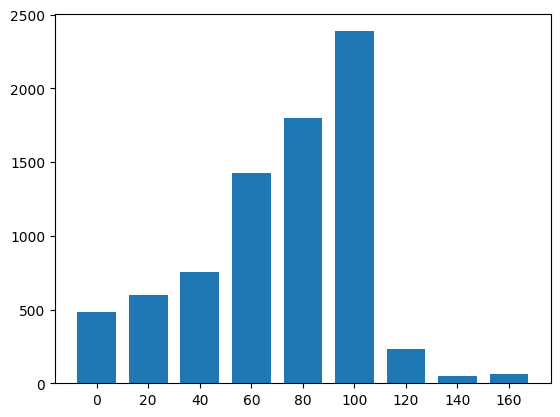

In [ ]:
plt.bar(bins[1:-1], bin_cnts, width=15)  # notice the peak around 80-100 degrees - makes sense because we have the horizontal edge where the roof is
plt.xticks(bins[1:-1]);

In [ ]:
# calculate HOG for the whole image
descr = np.zeros((grad.shape[1]//8, grad.shape[0]//8, 9))

for x in trange(grad.shape[1]//8):
    for y in range(grad.shape[0]//8):
        descr[y,x] = hog_descr(grad_mx[y*8:(y+1)*8, x*8:(x+1)*8], angles_mx[y*8:(y+1)*8, x*8:(x+1)*8])

  0%|          | 0/16 [00:00<?, ?it/s]

### Normalisation

Gradient magnitudes depend on lighting; if we changed the brightness of the image, the gradients will change as well - we want to counteract this by normalising the histograms. We could normalise each of the histograms individually but for better results we'll do it in `2x2` blocks (or `16x16` pixel regions).

In [ ]:
descr.shape

(16, 16, 9)

In [ ]:
descr_norm = np.zeros_like(descr)
for x in range(descr.shape[1]-1):
    for y in range(descr.shape[0]-1):
        d = descr[y:y+2, x:x+2] # extract histograms for the 4 blocks
        descr_norm[y:y+2,x:x+2] += d / np.sqrt((d**2).sum()) # L2 normalization

The problem is that some descriptors are normalised multiple times!

In [ ]:
dv = np.full(descr_norm.shape[:2], 4)
a = np.array([1] + (descr.shape[0]-2)*[2] + [1])
dv[0, :] = a
dv[-1,:] = a
dv[:, 0] = a
dv[:,-1] = a
dv

array([[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2],
       [1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1]])

In [ ]:
descr_norm /= dv[...,None] # normalised descriptor for a 128x128px car
descr_norm.shape, descr_norm[:4,:4]

((16, 16, 9),
 array([[[0.26967279, 0.02313375, 0.03065373, 0.07972787, 0.10021127,
          0.05751026, 0.02784062, 0.02196049, 0.        ],
         [0.31824941, 0.06705094, 0.10285551, 0.1684474 , 0.10315931,
          0.09071236, 0.07153202, 0.09161688, 0.14134329],
         [0.06014576, 0.        , 0.00240381, 0.08760564, 0.44069922,
          0.29480411, 0.06270326, 0.06854521, 0.04721022],
         [0.25097963, 0.16001686, 0.03281765, 0.02794918, 0.02404027,
          0.04623458, 0.11867775, 0.04998156, 0.06850247]],
 
        [[0.18762102, 0.        , 0.07035788, 0.02345263, 0.09381051,
          0.09381051, 0.        , 0.        , 0.        ],
         [0.48290107, 0.10278747, 0.19093142, 0.06430197, 0.05738754,
          0.06108484, 0.04890794, 0.03847696, 0.15517092],
         [0.07430037, 0.13236889, 0.10579316, 0.08751943, 0.19971874,
          0.18280893, 0.03074177, 0.06325402, 0.0502947 ],
         [0.21390757, 0.19634787, 0.06221571, 0.02993901, 0.0056825 ,
          

## HOG in scikit-image

OpenCV has HOG implementation but at the time of writing it was very difficult to get a picture like the one on th right below, so using `scikit-learn` instead.

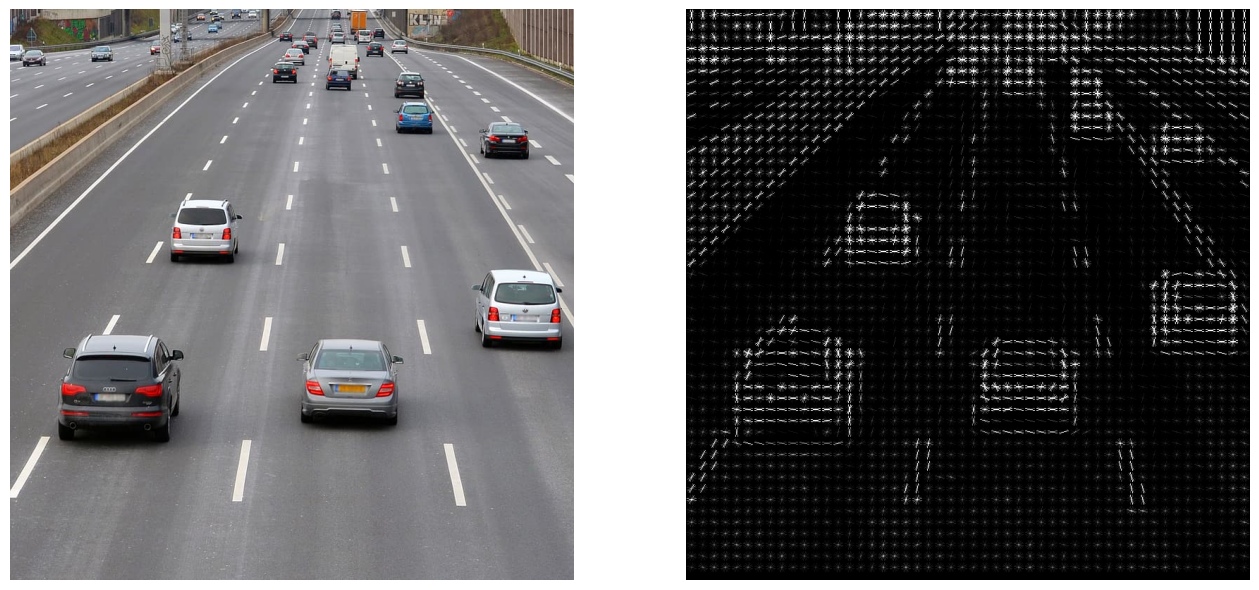

In [ ]:
from skimage.feature import hog
from skimage import data, exposure

fd, hog_image = hog(im, orientations=8, pixels_per_cell=(16,16), cells_per_block=(1,1), visualize=True, channel_axis=2)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

_, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax[0].axis('off'); ax[0].imshow(im[:,:,::-1]);
ax[1].axis('off'); ax[1].imshow(hog_image_rescaled, cmap=plt.cm.gray);

# HOG-based classifier - our first ML model!

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

In [ ]:
# one of the many ways of downloading a standard dataset (takes about 30s to run)
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [ ]:
X.shape

(70000, 784)

<Axes: >

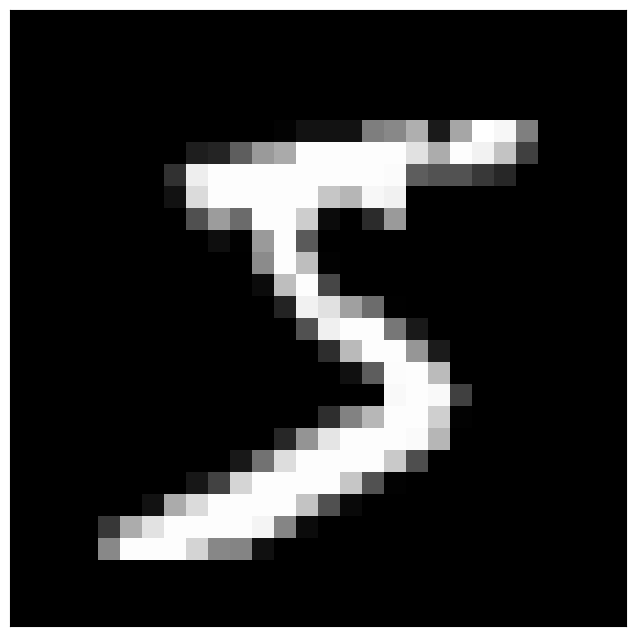

In [ ]:
show_img(X[0].reshape(28,28).astype(int))

In [ ]:
perm = np.random.permutation(X.shape[0])
Xtr, ytr = X[perm[:1000]], y[perm[:1000]]
Xte, yte = X[perm[-1000:]], y[perm[-1000:]]

In [ ]:
scaler = StandardScaler().fit(Xtr)
clf = LogisticRegression(solver='saga', tol=0.01)
clf.fit(scaler.transform(Xtr), ytr)
score = clf.score(scaler.transform(Xte), yte)
score

0.855

In [ ]:
Xtrf = [hog(x.reshape(28,28).astype(int), orientations=9, pixels_per_cell=(7,7), cells_per_block=(2,2), transform_sqrt=True, block_norm='L1') for x in Xtr]
Xtef = [hog(x.reshape(28,28).astype(int), orientations=9, pixels_per_cell=(7,7), cells_per_block=(2,2), transform_sqrt=True, block_norm='L1') for x in Xte]

In [ ]:
scaler = StandardScaler().fit(Xtrf)
clf = LogisticRegression(solver='saga', tol=0.01)
clf.fit(scaler.transform(Xtrf), ytr)
score = clf.score(scaler.transform(Xtef), yte)
score

0.934

# Homework

*   Build a better digit classifier using `scikit-learn` and HOG, and/or
*   Use HOG to find Wally

